In [1]:
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

import numpy as np

from scipy.special import jv #Bessel Function
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
# To make plots nice: 
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)

## Functions: Generate Spectogram, Plot Spectrogram, Find Local Mins, then Generate g(n,e), 

In [3]:
# Function to generate a spectogram (with fftlength fftlen)for the GW waveform with initial 
# eccentricity e0 and masses m1 and m2
def genSpectrogram(e0, m1, m2, fftlen):
    
    hp, hc = get_td_waveform(approximant="EccentricTD",
                         mass1=m1,
                         mass2=m1,
                         delta_t=1.0/4096,
                         eccentricity=e0,
                         f_lower=20)

    h = TimeSeries(hp+hc, times=hp.sample_times)   # is it okay to just add the two????
    #h = TimeSeries((hp**2 + hc**2)**(1.0/2), times=hp.sample_times) # quadtrature sum
    
    specgram = h.spectrogram(fftlen, fftlength=fftlen, overlap=fftlen/2.0)
    
    return specgram

In [4]:
# Function to plot a spectrogram
def plotSpectrogram(specgram, e0, m1, m2): 
    plot = specgram.plot()
    ax = plot.gca()
    ax.set_ylim(5, 100)
    #ax.set_yscale('log')
    ax.set_title(r'$e_0$ = {}, $m_1$ = {}, $m_2$ = {} $M_\odot$'.format(e0,m1,m2))
    plot.add_colorbar(label='GW strain PSD')
    plot.show()

In [5]:
# Function to find local minima in an array
def localMin(y,x):

    min_y = []
    min_x = []
    min_idx = []

    for i in range(1,len(y)-1):
    
        y_val = y[i]
        x_val = x[i]
    
        if y_val < y[i-1] and y_val < y[i+1]: 
            min_y.append(y_val.value)
            min_x.append(x_val.value)
            min_idx.append(i)

    #print "Local max y values:", max_y
    #print "Corresponding x values:", max_x
    
    return min_y, min_x, min_idx

In [6]:
def genGneDist(e0, m1, m2, fftlen, nMax):

    # Generate spectogram
    specgram = genSpectrogram(e0, m1, m2, fftlen)
    
    # Uncomment line below if you want to plot the spectrogram
    #plotSpectrogram(specgram, e0, m1, m2)
    
    # Look at first bin
    power_bin1 = specgram[0]
    freqs = specgram.frequencies.value
    
    # Find local mins
    #min_power, min_freqs, min_idx = localMin(power_bin1, freqs)
    #print min_freqs
    
    # Hard coding frequency bins: 
    n = genNArray(nMax)
    harm = 10*n 
    delta_f = 4
    
    # Summing power in each harmonic
    Pn = []
    #n = []
    #for i,idx in enumerate(min_idx[:-1]):
        #idx2 = min_idx[i+1]
        #total = np.sum(power_bin1[idx:idx2].value)
        #Pn.append(total)
        #n.append(i+1)
    for h in harm: 
        idx_upper = np.where(freqs == (h+delta_f))[0][0]
        idx_lower = np.where(freqs == (h-delta_f))[0][0]
        total = np.sum(power_bin1[idx_lower:idx_upper].value)
        Pn.append(total)
        
    # Normalizing by power in n=2 harmonic
    norm = Pn[1]
    g = Pn/norm
    
    return g, n

In [116]:
# Testing for BBH with e0 = 0.3, m1=m2=2 solar masses, and using fftlength of 1 for spectrogram
g_spec_test,n_spec_test = genGneDist(0.3, 2, 2, 1, 15)

(0, 15)

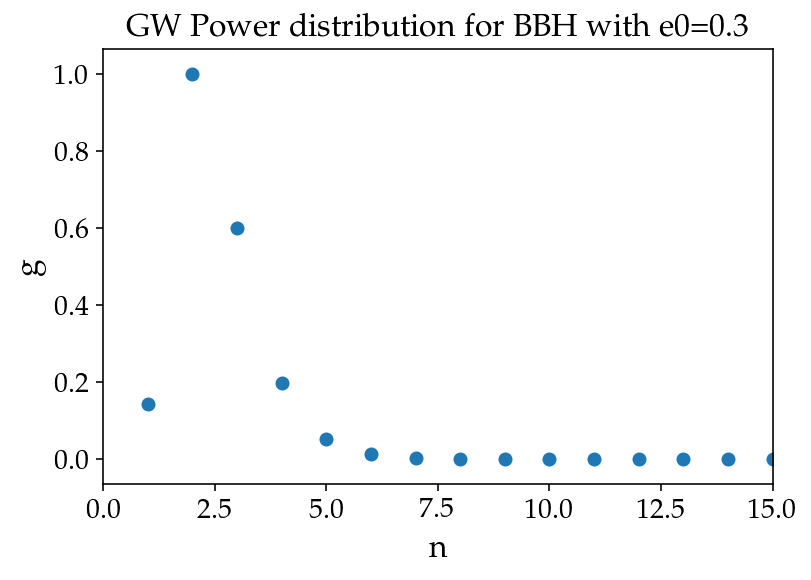

In [117]:
plt.scatter(n_spec_test,g_spec_test)
plt.title("GW Power distribution for BBH with e0=0.3", fontsize=16)
plt.xlabel("n", fontsize=16)
plt.ylabel("g", fontsize=16)
plt.xlim(0,15)

## Generating theoretical model for g(n,e) using equations from Maggiore

In [7]:
# Function to calculate g, the normalized power, in the nth harmonic for a BBH with eccentricity e
def g(n,e): 
    
    a = 1.0/(1 - e**2)
    b = (1 - e**2)**(-1.0/2)
    
    An = ((a**2)/n)*(jv(n - 2, n*e) - jv(n + 2, n*e) - 2*e*(jv(n - 1, n*e) - jv(n + 1, n*e)))
    Bn = ((b**2)/n)*(jv(n + 2, n*e) - jv(n - 2, n*e))
    Cn = (a*b/n)*(jv(n + 2, n*e) + jv(n - 2, n*e) - e*(jv(n + 1, n*e)  + jv(n - 1, n*e)))
    
    gne = n**4/(94*a**4)*(An**2 + Bn**2 + 3*Cn**2 - An*Bn) # n^6 -> n^4
    
    return gne

In [8]:
# Normalized g(n,e) by g(2,e)
def gnorm(n,e):
    
    gne = g(n,e)
    norm = g(2,e)
    
    return gne/norm

In [9]:
# Function to calculate g on a log scale 
def glog(n,e): 
    
    gnormalized = gnorm(n,e) 
    
    return np.log10(gnormalized)

In [10]:
# Array of harmonics we want to include in g(n,e) curve
def genNArray(nMax):
    n = np.arange(1,nMax+1)
    return n

In [98]:
# Testing for e0=0.3
n_theoretical_test = genNArray(15)
g_theoretical_test = []
for n in n_theoretical_test: 
    g_theoretical_test.append(gnorm(n,0.3))

(0, 15)

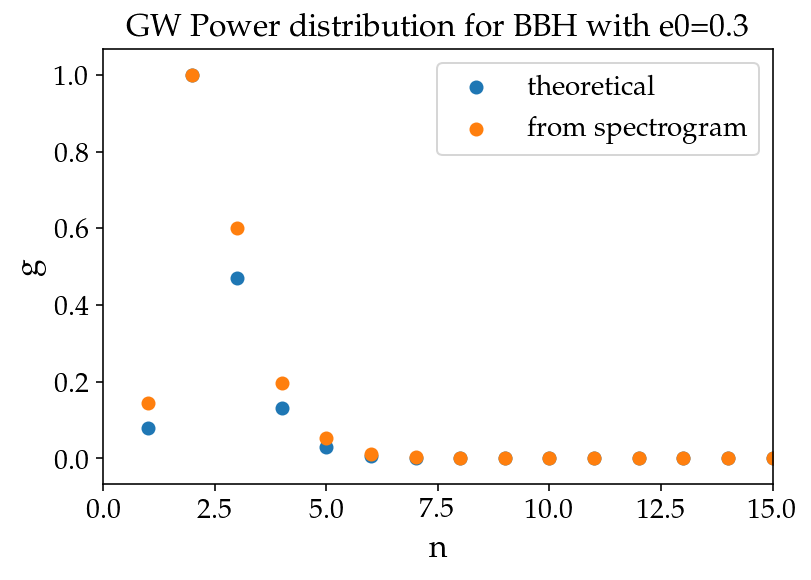

In [109]:
plt.scatter(n_theoretical_test, g_theoretical_test, label='theoretical')
plt.scatter(n_spec_test, g_spec_test, label = 'from spectrogram')
plt.title("GW Power distribution for BBH with e0=0.3", fontsize=16)
plt.xlabel("n", fontsize=16)
plt.ylabel("g", fontsize=16)
plt.legend(fontsize=14)
plt.xlim(0,15)

## Curve Fitting

In [51]:
e_recov, covar = curve_fit(gnorm, n_spec_test, g_spec_test, p0=0.1)
e_fit = e_recov[0]

In [52]:
print e_fit
print covar

0.336064439119
[[  3.62273651e-06]]


In [53]:
g_bestfit_test = []
for n in n_spec_test: 
    g_bestfit_test.append(gnorm(n,e_fit))

(0, 15)

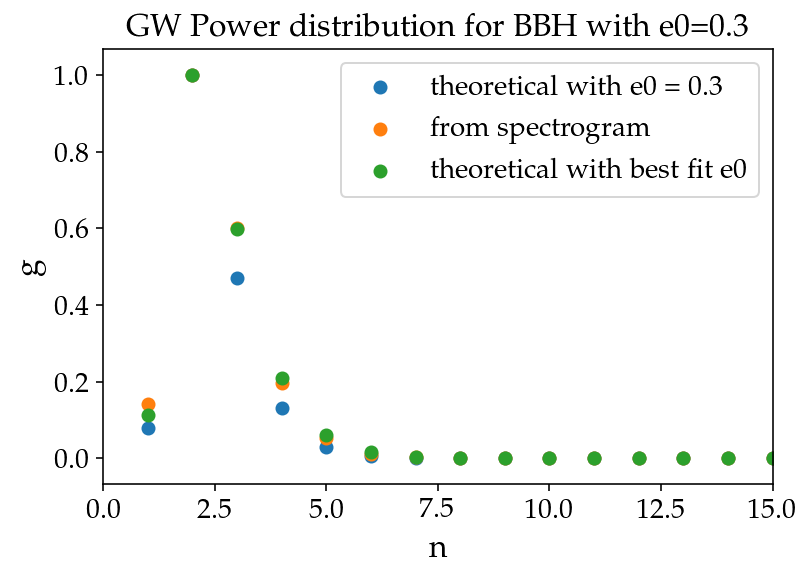

In [54]:
plt.scatter(n_theoretical_test, g_theoretical_test, label='theoretical with e0 = 0.3')
plt.scatter(n_spec_test, g_spec_test, label = 'from spectrogram')
plt.scatter(n_spec_test, g_bestfit_test, label = 'theoretical with best fit e0')
plt.title("GW Power distribution for BBH with e0=0.3", fontsize=16)
plt.xlabel("n", fontsize=16)
plt.ylabel("g", fontsize=16)
plt.legend(fontsize=14)
plt.xlim(0,15)

In [11]:
# Turn it into a function: 

def bestFitEcc(e0, m1, m2, fftlen, nMax, returnAll): 
    
    # Generate g(n,e) distribution from spectrogram: 
    g_spec_all, n_all = genGneDist(e0, m1, m2, fftlen, nMax)
    
    # Redefine n to just be the harmonics we want
    n = genNArray(nMax)
    g_spec = g_spec_all[0:nMax]
    
    # Curve fitting using theoretical curve:
    e, covar = curve_fit(gnorm, n, g_spec, p0=0.1)
    e_fit = e[0]
    
    g_theoretical = []
    g_fit = []
    for i in n:
        g_theoretical.append(gnorm(i,e0))
        g_fit.append(gnorm(i,e_fit))
        
    print "Injected e0 = {}".format(e0)
    print "Recovered e0 = {}".format(e_fit)
    
    if returnAll: 
        return e0, e_fit, g_spec_log, g_theoretical, g_fit, n
    else:
        return e_fit

In [57]:
# Lets do it on a log scale! 

def bestFitEccLog(e0, m1, m2, fftlen, nMax, returnAll):
    
    # Generate g(n,e) distribution from spectrogram: 
    g_spec_all, n_all = genGneDist(e0, m1, m2, fftlen, nMax)
    
    # Redefine n to just be the harmonics we want
    n = genNArray(nMax)
    g_spec = g_spec_all[0:nMax]
    
    # Convert to log scale
    g_spec_log = np.log10(g_spec)
    
    # Curve fitting using theoretical curve:
    e, covar = curve_fit(glog, n, g_spec_log, p0=0.1)
    e_fit = e[0]
    
    g_theoretical = []
    g_fit = []
    for i in n:
        g_theoretical.append(glog(i,e0))
        g_fit.append(glog(i,e_fit))
        
    print "Injected e0 = {}".format(e0)
    print "Recovered e0 = {}".format(e_fit)
    
    if returnAll: 
        return e0, e_fit, g_spec_log, g_theoretical, g_fit, n
    else:
        return e_fit 

In [58]:
e0, e_fit_log, g_spec_log, g_theoretical_log, g_fit_log, n_log = bestFitEccLog(0.3, 3, 3, 1, 15, True)

Injected e0 = 0.3
Recovered e0 = 0.317287905291


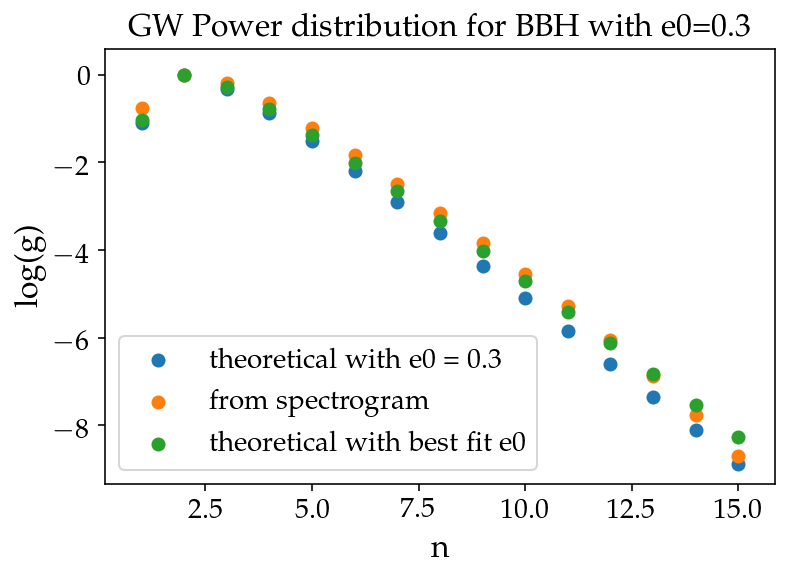

In [59]:
plt.scatter(n_log, g_theoretical_log, label='theoretical with e0 = 0.3')
plt.scatter(n_log, g_spec_log, label = 'from spectrogram')
plt.scatter(n_log, g_fit_log, label = 'theoretical with best fit e0')
plt.title("GW Power distribution for BBH with e0=0.3", fontsize=16)
plt.xlabel("n", fontsize=16)
plt.ylabel("log(g)", fontsize=16)
plt.legend(fontsize=14)

## Curve Fitting over a Range of Eccentricities

In [12]:
# Define our parameters
e0_inj = np.arange(0.01,0.81,0.01)
m1=2
m2=2
fftlen=1
nMax=15
returnAll = False 

In [13]:
e_fit_lin = []
#e_fit_log = []

for e0 in e0_inj: 
    e_lin = bestFitEcc(e0, m1, m2, fftlen, nMax, returnAll)
    e_fit_lin.append(e_lin)
    #e_log = bestFitEccLog(e0, m1, m2, fftlen, nMax, returnAll)
    #e_fit_log.append(e_log)

Injected e0 = 0.01
Recovered e0 = 0.0110116202719
Injected e0 = 0.02
Recovered e0 = 0.0220227997343
Injected e0 = 0.03
Recovered e0 = 0.0330372039997
Injected e0 = 0.04
Recovered e0 = 0.0440559416281
Injected e0 = 0.05
Recovered e0 = 0.0550803092377
Injected e0 = 0.06
Recovered e0 = 0.066111811389
Injected e0 = 0.07
Recovered e0 = 0.0771512847769
Injected e0 = 0.08
Recovered e0 = 0.0882008239394
Injected e0 = 0.09
Recovered e0 = 0.0992611478152
Injected e0 = 0.1
Recovered e0 = 0.11033512264
Injected e0 = 0.11
Recovered e0 = 0.121421375643
Injected e0 = 0.12
Recovered e0 = 0.132524909756
Injected e0 = 0.13
Recovered e0 = 0.143643204938
Injected e0 = 0.14
Recovered e0 = 0.154776632493
Injected e0 = 0.15
Recovered e0 = 0.165925583366
Injected e0 = 0.16
Recovered e0 = 0.177098025849
Injected e0 = 0.17
Recovered e0 = 0.188299331344
Injected e0 = 0.18
Recovered e0 = 0.199514478315
Injected e0 = 0.19
Recovered e0 = 0.210737493992
Injected e0 = 0.2
Recovered e0 = 0.222000060248
Injected e0 = 0

/home/pycbc/pycbc-software/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Injected e0 = 0.37
Recovered e0 = 0.417637363925
Injected e0 = 0.38
Recovered e0 = 0.42958040517
Injected e0 = 0.39
Recovered e0 = 0.441104938018
Injected e0 = 0.4
Recovered e0 = 0.453314373013
Injected e0 = 0.41
Recovered e0 = 0.464618721269
Injected e0 = 0.42
Recovered e0 = 0.477288005518
Injected e0 = 0.43
Recovered e0 = 0.488815706972
Injected e0 = 0.44
Recovered e0 = 0.50069042894
Injected e0 = 0.45
Recovered e0 = 0.512838500194
Injected e0 = 0.46
Recovered e0 = 0.525457989159
Injected e0 = 0.47
Recovered e0 = 0.53813215754
Injected e0 = 0.48
Recovered e0 = 0.549983875591
Injected e0 = 0.49
Recovered e0 = 0.563511347166
Injected e0 = 0.5
Recovered e0 = 0.575205964871
Injected e0 = 0.51
Recovered e0 = 0.588829771089
Injected e0 = 0.52
Recovered e0 = 0.602067452268
Injected e0 = 0.53
Recovered e0 = 0.614281397061
Injected e0 = 0.54
Recovered e0 = 0.999999972458
Injected e0 = 0.55
Recovered e0 = 0.999999978963
Injected e0 = 0.56
Recovered e0 = 0.65652986198
Injected e0 = 0.57
Recover

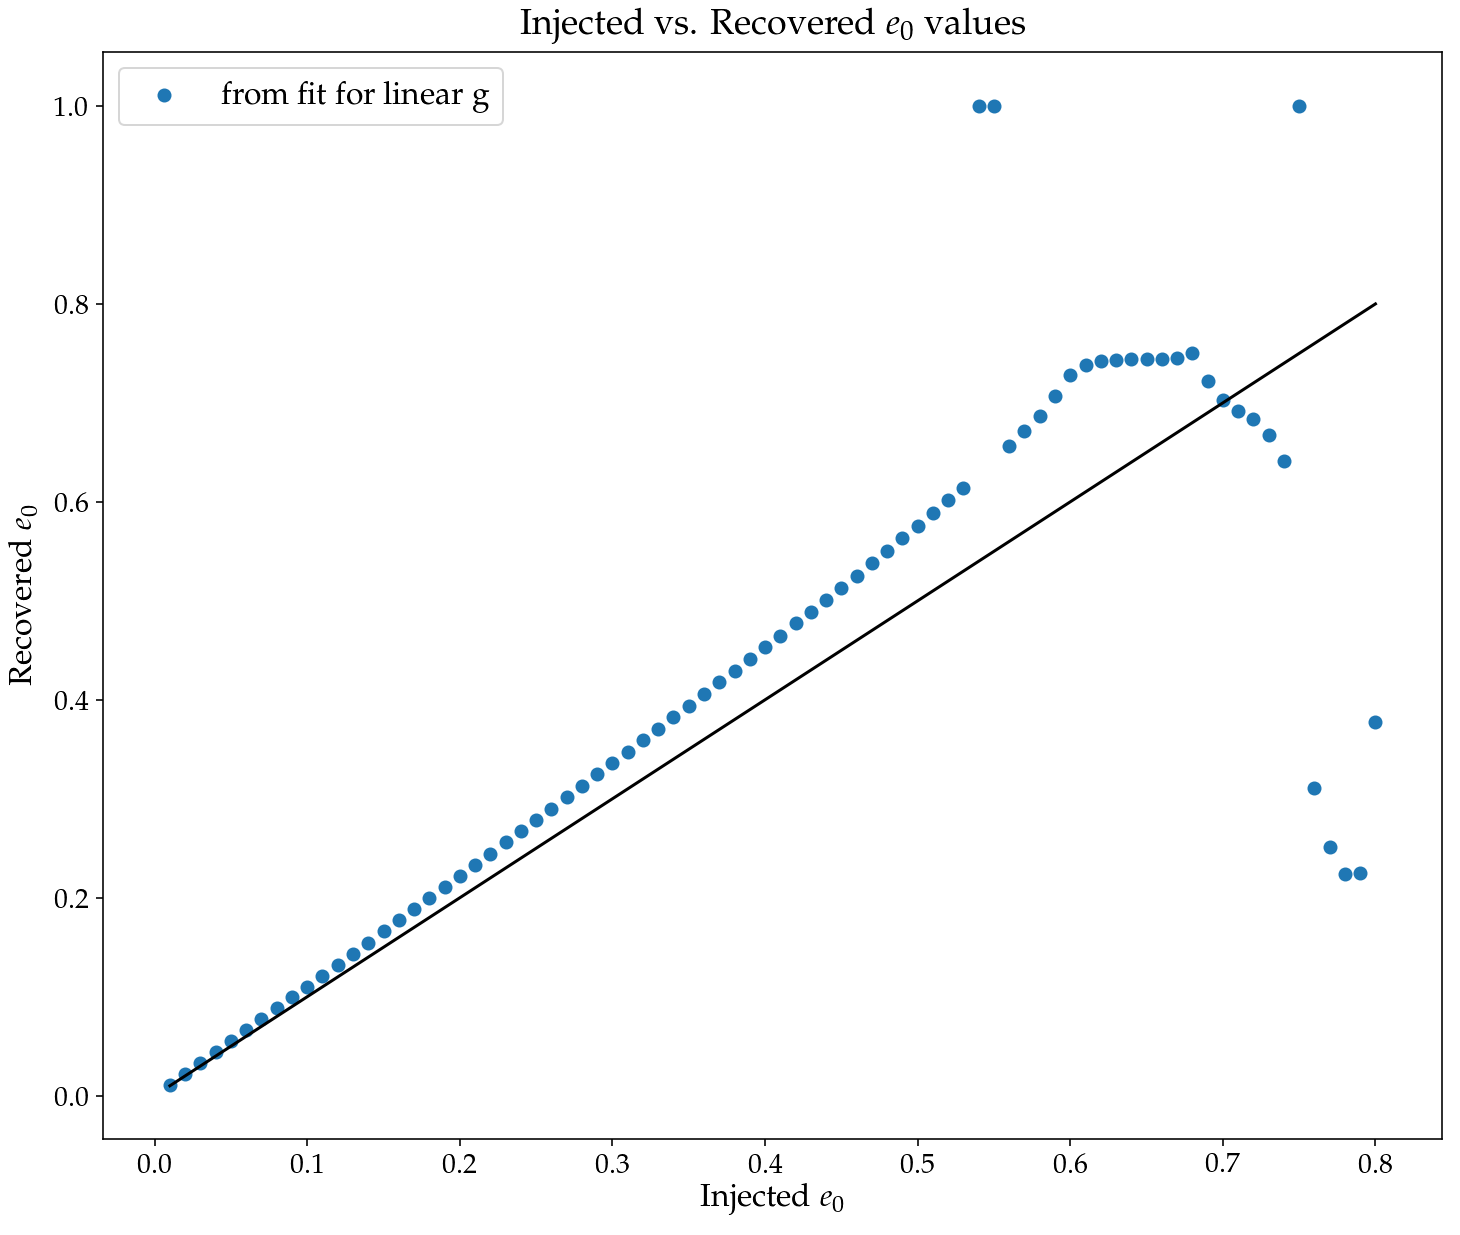

In [15]:
plt.figure(figsize=(12,10))
plt.plot(e0_inj, e0_inj, color='k')
plt.scatter(e0_inj, e_fit_lin, label='from fit for linear g')
plt.title(r"Injected vs. Recovered $e_0$ values", fontsize=18)
plt.xlabel(r"Injected $e_0$", fontsize=16)
plt.ylabel(r"Recovered $e_0$", fontsize=16)
plt.legend(fontsize=16)
#plt.xlim(0,0.53)
#plt.ylim(0,0.53)

In [63]:
# Lower mass, longer fftlen
e0_inj_long = np.arange(0.05, 0.85, 0.05)
m1=1
m2=1
fftlen=4
nMax=15

In [64]:
e_fit_lin_long = []
e_fit_log_long = []

for e0 in e0_inj_long: 
    e_lin = bestFitEcc(e0, m1, m2, fftlen, nMax, returnAll)
    e_fit_lin_long.append(e_lin)
    e_log = bestFitEccLog(e0, m1, m2, fftlen, nMax, returnAll)
    e_fit_log_long.append(e_log)

Injected e0 = 0.05
Recovered e0 = 0.052971079139
Injected e0 = 0.05
Recovered e0 = 0.107651821578
Injected e0 = 0.1
Recovered e0 = 0.106033659906
Injected e0 = 0.1
Recovered e0 = 0.125484583006
Injected e0 = 0.15
Recovered e0 = 0.159274420619
Injected e0 = 0.15
Recovered e0 = 0.156002953212
Injected e0 = 0.2
Recovered e0 = 0.212768163814
Injected e0 = 0.2
Recovered e0 = 0.206366899327
Injected e0 = 0.25
Recovered e0 = 0.266569944106
Injected e0 = 0.25
Recovered e0 = 0.258178468202
Injected e0 = 0.3
Recovered e0 = 0.320716736278
Injected e0 = 0.3
Recovered e0 = 0.310188751627
Injected e0 = 0.35
Recovered e0 = 0.375247629058
Injected e0 = 0.35
Recovered e0 = 0.36249263567


/home/pycbc/pycbc-software/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Injected e0 = 0.4
Recovered e0 = 0.430240526435
Injected e0 = 0.4
Recovered e0 = 0.415254736598
Injected e0 = 0.45
Recovered e0 = 0.485857839217
Injected e0 = 0.45
Recovered e0 = 0.468768747396
Injected e0 = 0.5
Recovered e0 = 0.542416594378
Injected e0 = 0.5
Recovered e0 = 0.523603835486
Injected e0 = 0.55
Recovered e0 = 0.600649289739
Injected e0 = 0.55
Recovered e0 = 0.580986435149
Injected e0 = 0.6
Recovered e0 = 0.848302984518
Injected e0 = 0.6
Recovered e0 = 0.639265682753
Injected e0 = 0.65
Recovered e0 = 0.736784492368
Injected e0 = 0.65
Recovered e0 = 0.72589109288
Injected e0 = 0.7
Recovered e0 = 0.746777910363
Injected e0 = 0.7
Recovered e0 = 0.748750478124
Injected e0 = 0.75
Recovered e0 = 0.836730876032
Injected e0 = 0.75
Recovered e0 = 0.681096451226
Injected e0 = 0.8
Recovered e0 = 0.403198738777
Injected e0 = 0.8
Recovered e0 = 0.612610798482


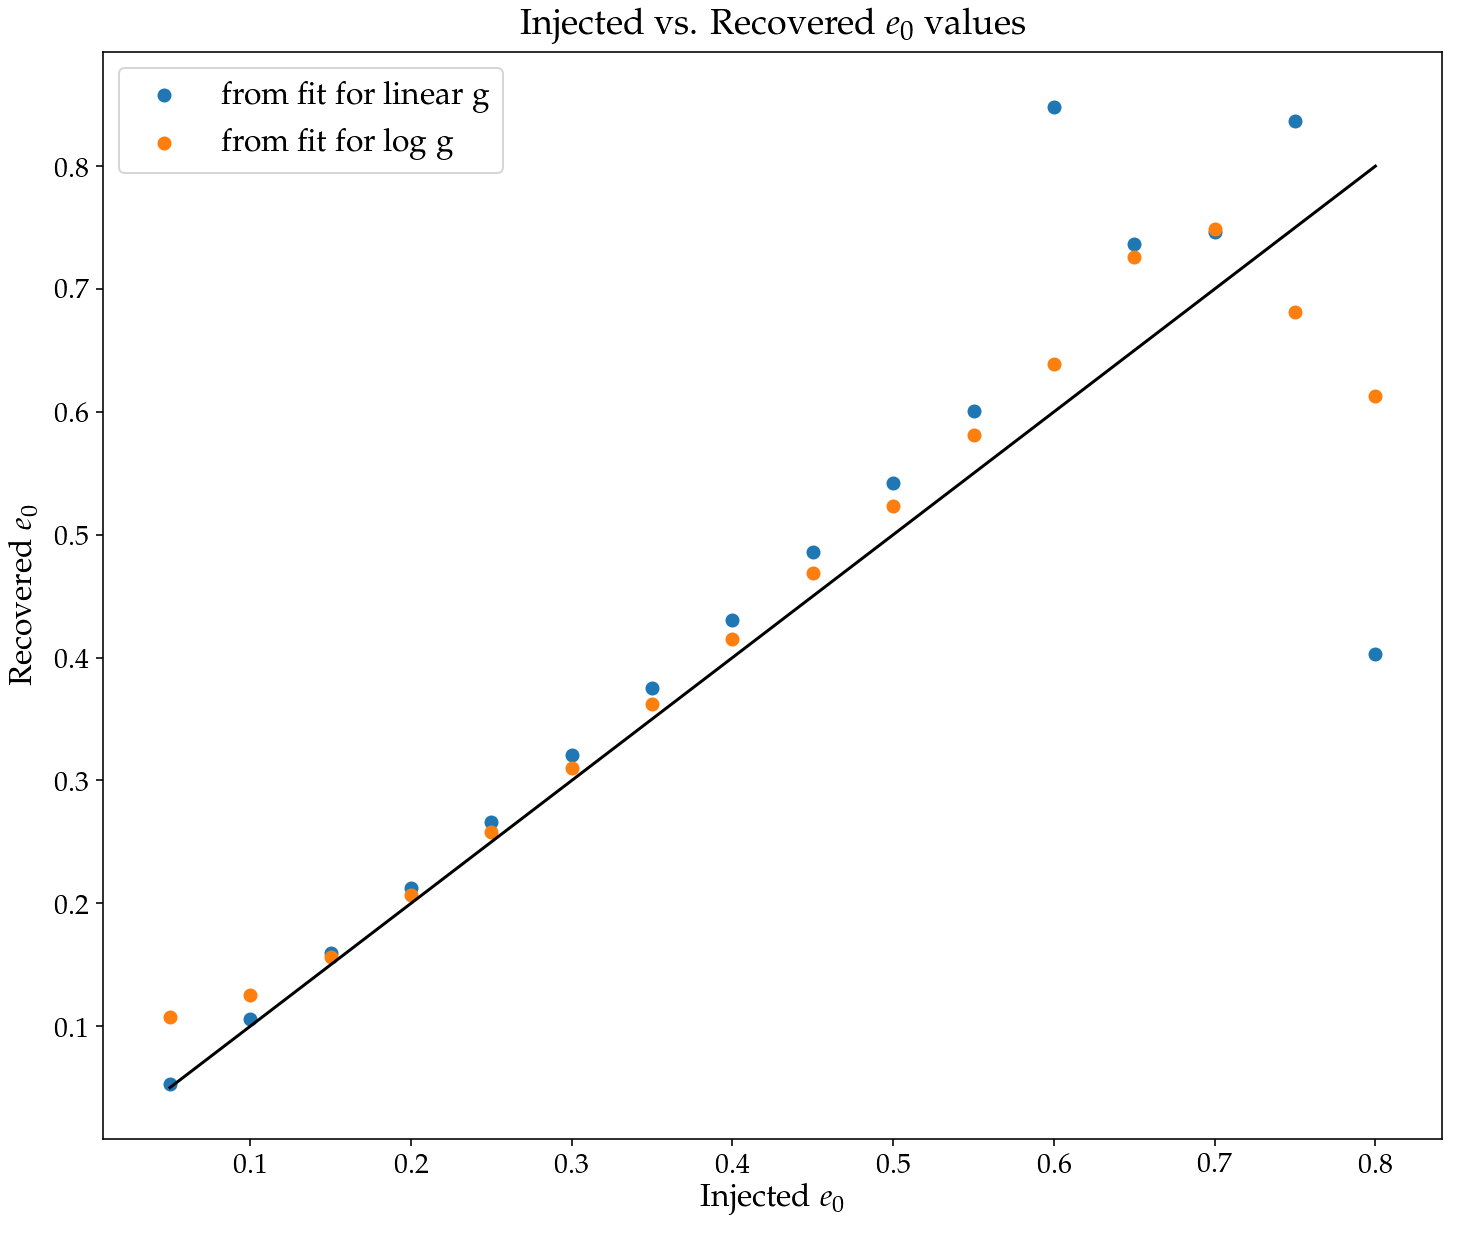

In [65]:
plt.figure(figsize=(12,10))
plt.plot(e0_inj_long, e0_inj_long, color='k')
plt.scatter(e0_inj_long, e_fit_lin_long, label='from fit for linear g')
plt.scatter(e0_inj_long, e_fit_log_long, label='from fit for log g')
plt.title(r"Injected vs. Recovered $e_0$ values", fontsize=18)
plt.xlabel(r"Injected $e_0$", fontsize=16)
plt.ylabel(r"Recovered $e_0$", fontsize=16)
plt.legend(fontsize=16)

In [81]:
# Higher eccentricities - include more harmonics
e0_inj_high = np.arange(0.50, 0.85, 0.05)
m1=1
m2=1
fftlen=4
nMax=25

In [87]:
e_fit_lin_high = []
e_fit_log_high = []

for e0 in e0_inj_high: 
    e_lin = bestFitEcc(e0, m1, m2, fftlen, nMax, returnAll)
    e_fit_lin_high.append(e_lin)
    e_log = bestFitEccLog(e0, m1, m2, fftlen, nMax, returnAll)
    e_fit_log_high.append(e_log)

/home/pycbc/pycbc-software/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Injected e0 = 0.5
Recovered e0 = 0.542416507123
Injected e0 = 0.5
Recovered e0 = 0.516064720294
Injected e0 = 0.55
Recovered e0 = 0.600645960294
Injected e0 = 0.55
Recovered e0 = 0.570645231489
Injected e0 = 0.6
Recovered e0 = 0.999999966874
Injected e0 = 0.6
Recovered e0 = 0.627709301028
Injected e0 = 0.65
Recovered e0 = 0.735646469424
Injected e0 = 0.65
Recovered e0 = 0.702764447654
Injected e0 = 0.7
Recovered e0 = 0.747269617824
Injected e0 = 0.7
Recovered e0 = 0.758258073683
Injected e0 = 0.75
Recovered e0 = 0.840757147971
Injected e0 = 0.75
Recovered e0 = 0.7184498169
Injected e0 = 0.8
Recovered e0 = 0.403198131494
Injected e0 = 0.8
Recovered e0 = 0.686637242091


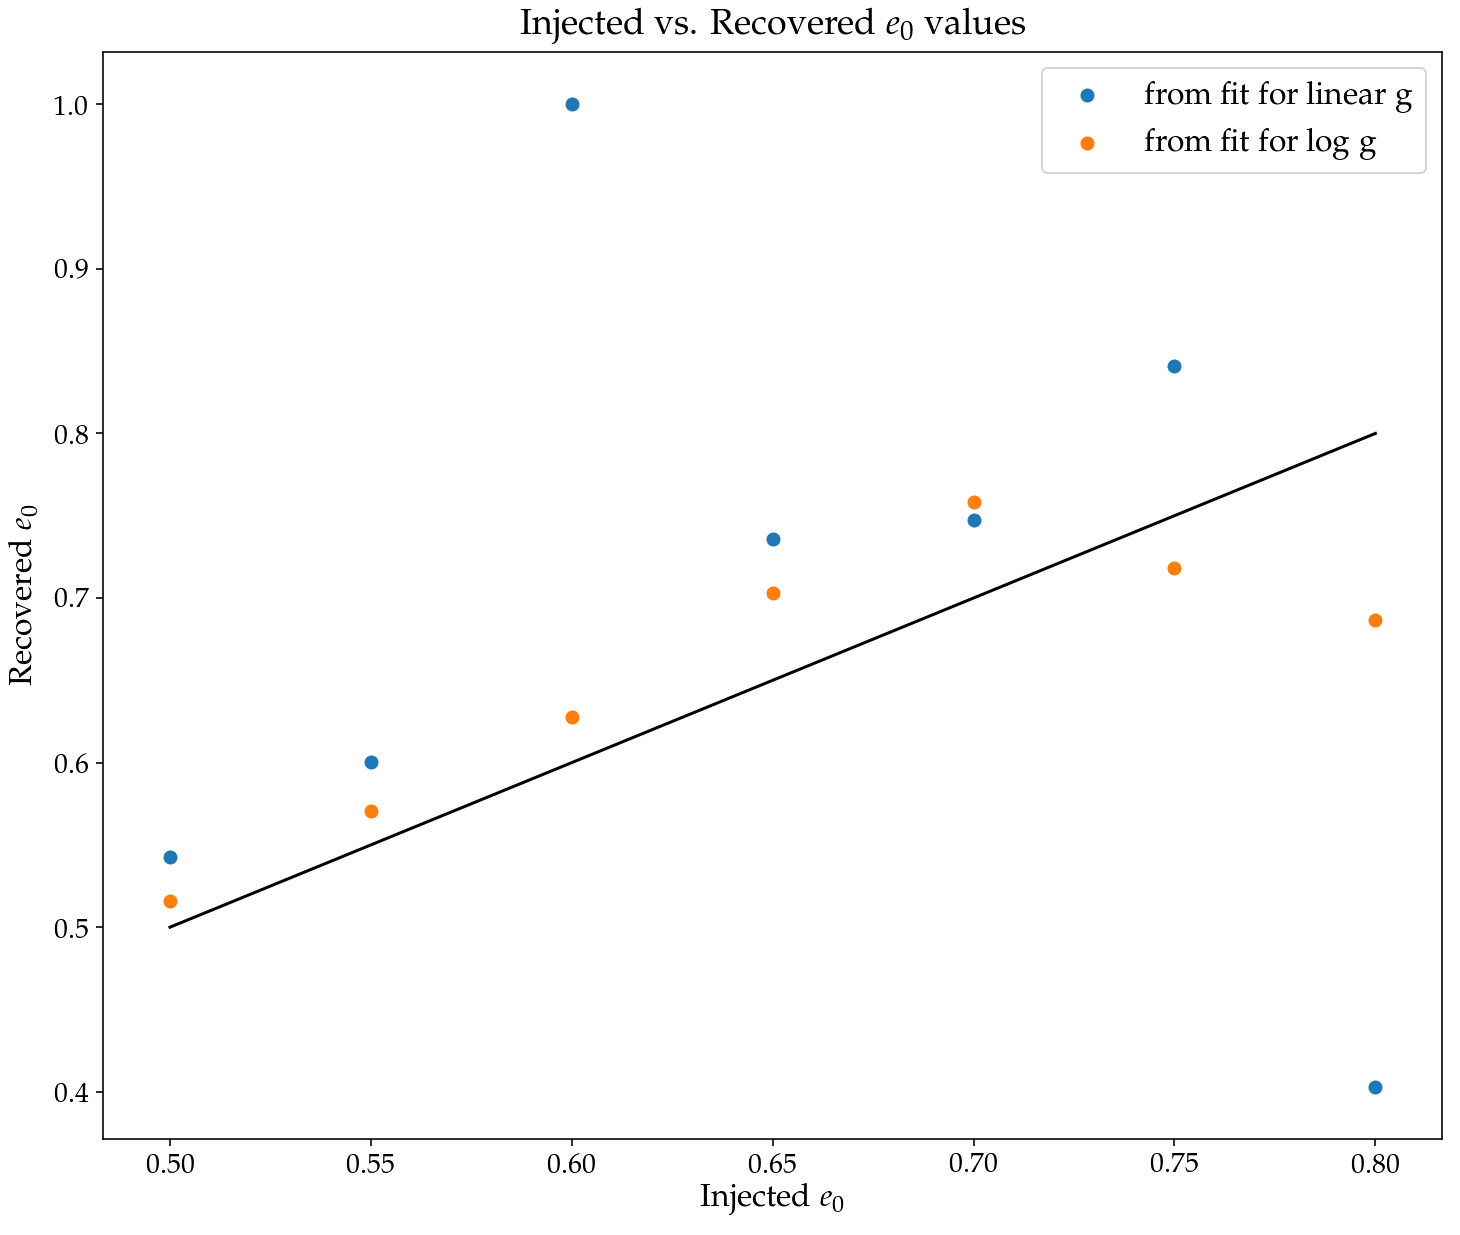

In [88]:
plt.figure(figsize=(12,10))
plt.plot(e0_inj_high, e0_inj_high, color='k')
plt.scatter(e0_inj_high, e_fit_lin_high, label='from fit for linear g')
plt.scatter(e0_inj_high, e_fit_log_high, label='from fit for log g')
plt.title(r"Injected vs. Recovered $e_0$ values", fontsize=18)
plt.xlabel(r"Injected $e_0$", fontsize=16)
plt.ylabel(r"Recovered $e_0$", fontsize=16)
plt.legend(fontsize=16)